# Market Price Dynamics

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/partially-controllable-MDP


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def simulate_bounded_discretized_gbm(S0, mu, sigma, T, N, S_min, S_max, granularity, rng):
    """
    Simulates GBM with price discretization (tick size) and hard boundaries.
    """
    # 1. Define time step
    tau = T / N
    
    # 2. Generate Brownian increments
    Z = rng.normal(0, 1, (N,))
    
    # 3. Calculate drift and diffusion
    drift_term = (mu - 0.5 * sigma**2) * tau
    diffusion_term = sigma * np.sqrt(tau) * Z
    
    # 4. Compute log returns
    log_return = drift_term + diffusion_term
    
    # 5. Construct raw price paths
    log_return_with_start = np.insert(log_return, 0, 0.0)
    cumulative_log_return = np.cumsum(log_return_with_start, axis=0)
    raw_path = S0 * np.exp(cumulative_log_return)
    
    # --- NEW LOGIC: DISCRETIZATION & BOUNDARIES ---
    
    # A. Apply Granularity (Tick Size)
    # Divide by tick size, round to nearest integer, multiply back
    discretized_path = np.round(raw_path / granularity) * granularity
    
    # B. Apply S_min and S_max (Clamping)
    # Values above S_max become S_max; values below S_min become S_min
    final_path = np.clip(discretized_path, S_min, S_max)
    
    time_grid = np.linspace(0, T, N + 1)
    
    return time_grid, final_path

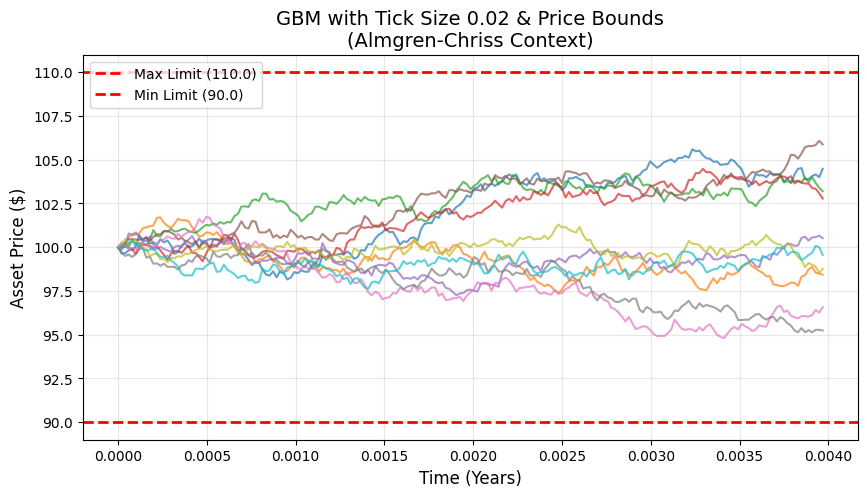

In [5]:
# --- Configuration for an Intraday Execution ---
S0 = 100.0         # Initial Price
S_max = 110.0      # Max Price
S_min = 90.0       # Min Price
granularity = 0.02 # Discretization (Tick Size)
sigma = 0.50       # 30% Volatility
mu = 0.0           # Zero drift (standard assumption for short-term execution)
T = 1/252          # 1 Trading Day (assuming 252 trading days/year)
N = 200            # Split the day into 200 intervals
num_sims = 10      # Generate 10 scenarios
seed = 1234

rng = np.random.default_rng(seed)

# Run Simulation
time_grid, price_paths = [], []

for _ in range(num_sims):
    #S0 = S_min + rng.integers(0, 1000) * granularity
    time, price = simulate_bounded_discretized_gbm(S0, mu, sigma, T, N, S_min, S_max, granularity, rng)
    time_grid.append(time)
    price_paths.append(price)
    
# --- Visualization ---
plt.figure(figsize=(10, 5))

# Plot the paths
for i in range(num_sims):
    plt.plot(time_grid[i], price_paths[i], lw=1.5, alpha=0.7)

# Add boundary lines
plt.axhline(y=S_max, color='r', linestyle='--', linewidth=2, label=f'Max Limit ({S_max})')
plt.axhline(y=S_min, color='r', linestyle='--', linewidth=2, label=f'Min Limit ({S_min})')

plt.title(f"GBM with Tick Size {granularity} & Price Bounds\n(Almgren-Chriss Context)", fontsize=14)
plt.xlabel("Time (Years)", fontsize=12)
plt.ylabel("Asset Price ($)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()

In [6]:
T/N

1.984126984126984e-05

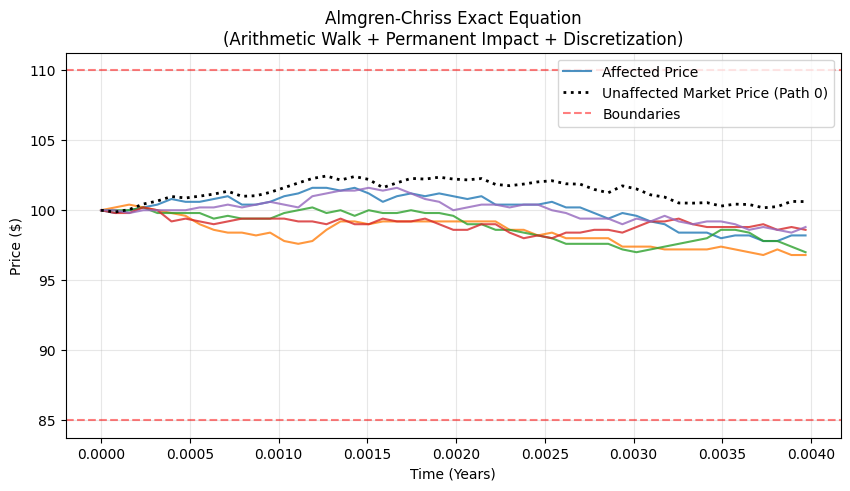

In [7]:
def simulate_almgren_arithmetic_exact(S0, sigma, T, N, X, gamma, S_min, S_max, granularity, n_sims=1):
    """
    Implements the exact equation from the image:
    S_k = S_0 + sigma * sum(tau^1/2 * xi) - gamma * (X - x_k)
    
    Parameters:
    X     : float : Total initial Inventory (shares to sell)
    gamma : float : Permanent impact parameter ($ drop per share sold)
    """
    dt = T / N  # This is 'tau' in the equation
    
    # --- 1. The Random Component (Middle Term) ---
    # "sigma * sum(tau^1/2 * xi)"
    # Generate standard normal noise (xi)
    xi = np.random.normal(0, 1, (N, n_sims))
    
    # Scale by volatility and square root of time
    random_increments = sigma * np.sqrt(dt) * xi
    
    # Add a row of zeros at the start (S_0 has no noise added yet)
    random_increments = np.vstack([np.zeros((1, n_sims)), random_increments])
    
    # Calculate Cumulative Sum (The Sigma Summation symbol)
    # This creates the pure Arithmetic Brownian Motion path
    random_walk_component = np.cumsum(random_increments, axis=0)
    
    # --- 2. The Impact Component (Last Term) ---
    # "gamma * (X - x_k)"
    # We assume a Linear Liquidation (TWAP) for x_k
    # Inventory starts at X and goes to 0 linearly
    x_k = np.linspace(X, 0, N + 1) 
    
    # Amount sold so far = (X - x_k)
    # Reshape for broadcasting across simulations
    amount_sold = (X - x_k).reshape(-1, 1)
    
    # Permanent Impact is gamma * amount_sold
    impact_component = gamma * amount_sold
    
    # --- 3. Combine Terms (The Full Equation) ---
    # S_k = S_0 + Random_Walk - Impact
    raw_paths = S0 + random_walk_component - impact_component
    
    # --- 4. Apply User Constraints (Discretization & Bounds) ---
    
    # Apply Granularity (Tick Size)
    discretized_paths = np.round(raw_paths / granularity) * granularity
    
    # Apply S_min and S_max (Clamping)
    final_paths = np.clip(discretized_paths, S_min, S_max)
    
    time_grid = np.linspace(0, T, N + 1)
    
    return time_grid, final_paths, random_walk_component

# --- Configuration ---
S0 = 100.0
S_max = 110.0
S_min = 85.0      # Lowered slightly to see impact
granularity = 0.2 # Tick size
sigma = 0.30 * S0 # Almgren uses absolute volatility ($), not %. So we approximate $ vol.
T = 1/252         # 1 Day
N = 50            # 50 intervals
num_sims = 5

# Execution Parameters
Total_Inventory_X = 100000  # Selling 100k shares
Gamma = 2.5e-5              # Impact: Price drops $2.50 total for selling 100k shares (2.5e-5 * 100k = 2.5)

# Run Simulation
time_grid, price_paths, pure_rw = simulate_almgren_arithmetic_exact(
    S0, sigma, T, N, Total_Inventory_X, Gamma, S_min, S_max, granularity, num_sims
)

# --- Visualization ---
plt.figure(figsize=(10, 5))

# Plot simulated paths (affected by selling)
for i in range(num_sims):
    plt.plot(time_grid, price_paths[:, i], lw=1.5, alpha=0.8, label="Affected Price" if i==0 else "")

# Plot the "Fair Price" (What price would be if we didn't sell) for the first path only
# Fair price = S0 + Random Walk (no gamma term)
fair_price_ex = S0 + pure_rw[:, 0]
plt.plot(time_grid, fair_price_ex, color='black', linestyle=':', linewidth=2, label="Unaffected Market Price (Path 0)")

plt.axhline(y=S_max, color='r', linestyle='--', alpha=0.5, label='Boundaries')
plt.axhline(y=S_min, color='r', linestyle='--', alpha=0.5)

plt.title("Almgren-Chriss Exact Equation\n(Arithmetic Walk + Permanent Impact + Discretization)")
plt.xlabel("Time (Years)")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()